# PCA vs Autoencoder
In slides, there is a graph of two methods' comparation.

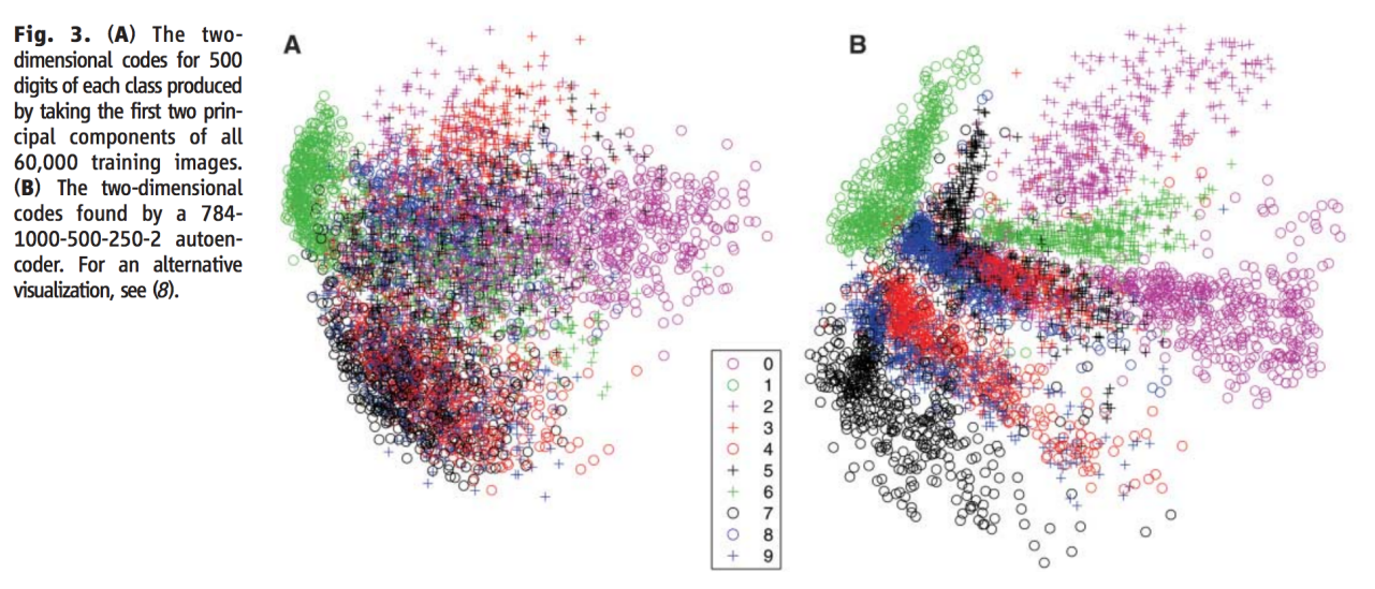

ref: Geoffrey E. Hinton, Ruslan R. Salakhutdinov.Reducing the Dimensionality of Data with Neural Networks. Science,2006

In [8]:
# import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
from sklearn.decomposition import PCA
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor

In [9]:
# init device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# load MNIST dataset
train_dataset = MNIST(root='./data', train=True, transform=ToTensor(), download=True)
test_dataset = MNIST(root='./data', train=False, transform=ToTensor(), download=True)

# extract data & label 
x_train = train_dataset.data.numpy().reshape(-1, 28*28) / 255.0  # flatten & normalization
y_train = train_dataset.targets.numpy()
x_test = test_dataset.data.numpy().reshape(-1, 28*28) / 255.0
y_test = test_dataset.targets.numpy()

# 500 samples for each（match the paper）
def sample_per_class(x, y, n=500):
    sampled_x, sampled_y = [], []
    for cls in range(10):
        mask = (y == cls)
        cls_x = x[mask][:n]
        cls_y = y[mask][:n]
        sampled_x.append(cls_x)
        sampled_y.append(cls_y)
    return np.vstack(sampled_x), np.hstack(sampled_y)

x_train_sampled, y_train_sampled = sample_per_class(x_train, y_train)
x_test_sampled, y_test_sampled = sample_per_class(x_test, y_test)

# translate to PyTorch tensor and deployment
x_train_tensor = torch.tensor(x_train_sampled, dtype=torch.float32).to(device)
x_test_tensor = torch.tensor(x_test_sampled, dtype=torch.float32).to(device)

## Principal Component Analysis (PCA)
PCA is a technique used to simplify complex datasets by highlighting their key patterns and reducing their dimensions, while losing as little information as possible.

1. Standardize the Data
PCA is sensitive to the scale of the features. First standardize all features to have a mean of 0 and a standard deviation of 1.

2. Calculate the Covariance Matrix

3.  Find the Eigenvectors and Eigenvalues of the Covariance Matrix

4. Sort the Components and Choose a Subset
Sort the eigenvectors by their eigenvalues, from highest to lowest. You can now decide how many of the top components to keep. 

5. Transform the Data
Project the original standardized data onto the selected principal components. This creates a new dataset with fewer dimensions.

![PCA1-smaller-smaller.gif](http://www.billconnelly.net/wp-content/uploads/2021/05/PCA1-smaller-smaller.gif)


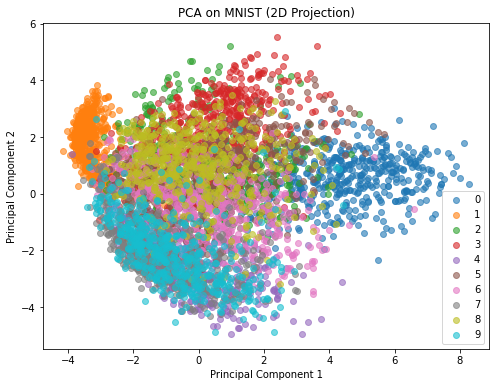

In [10]:
## PCA reduce dims to 2 dims
pca = PCA(n_components=2)
pca_train = pca.fit_transform(x_train_sampled)
pca_test = pca.transform(x_test_sampled)

# visualization
plt.figure(figsize=(8, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']
for cls in range(10):
    mask = (y_train_sampled == cls)
    plt.scatter(pca_train[mask, 0], pca_train[mask, 1], c=colors[cls], label=str(cls), alpha=0.6)
plt.title('PCA on MNIST (2D Projection)')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.legend()
plt.show()

# Autoencoder

An autoencoder is a type of neural network designed to learn an efficient, compressed representation (encoding) of input data, typically for the purpose of dimensionality reduction or feature learning, by being trained to reconstruct its own input.

### Structure:

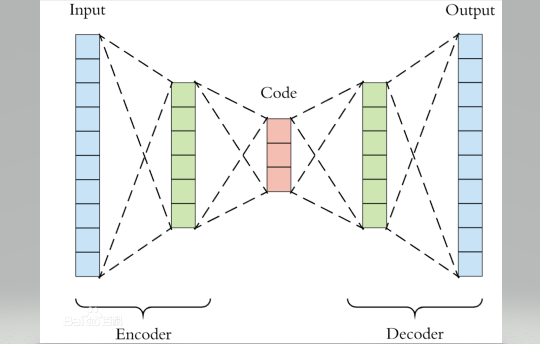


### main uses:

- Dimensionality Reduction: Like PCA, but often more powerful because they can learn non-linear relationships.

- Denoising: Train the autoencoder to reconstruct a clean image from a noisy one. It learns to ignore the noise and capture the true signal.

- Anomaly Detection: After training on "normal" data, an autoencoder will be bad at reconstructing "abnormal" or anomalous data. A high reconstruction error flags an anomaly.

- Feature Learning: The compressed representation (the "code") can be used as features for other machine learning tasks like classification.

- Image Generation (Variational Autoencoders): A more advanced type can generate new data that resembles the training data.



In [17]:
# define autoencoder（same as the structure in paper：784-1000-500-250-2-250-500-1000-784）
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        # encoder
        self.encoder = nn.Sequential(
            nn.Linear(784, 1000),
            nn.Sigmoid(),
            nn.Linear(1000, 500),
            nn.Sigmoid(),
            nn.Linear(500, 250),
            nn.Sigmoid(),
            nn.Linear(250, 2),
            nn.Sigmoid()  # 2 dim latent space
        )
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(2, 250),
            nn.Sigmoid(),
            nn.Linear(250, 500),
            nn.Sigmoid(),
            nn.Linear(500, 1000),
            nn.Sigmoid(),
            nn.Linear(1000, 784),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        z = self.encoder(x)
        x_recon = self.decoder(z)
        return x_recon, z
    
    def encode(self, x):
        return self.encoder(x)
    
# init model
model = Autoencoder().to(device)
criterion = nn.MSELoss()  # same in paper
optimizer = optim.Adam(model.parameters(), lr=0.001)

# data loader
train_loader = DataLoader(
    dataset=TensorDataset(x_train_tensor),
    batch_size=128,
    shuffle=True
)

In [18]:
# train 
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        x = batch[0]  
        optimizer.zero_grad()
        x_recon, _ = model(x)
        loss = criterion(x_recon, x)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    
    # loss
    model.eval()
    with torch.no_grad():
        x_recon_test, _ = model(x_test_tensor)
        val_loss = criterion(x_recon_test, x_test_tensor).item()
    
    if epoch % 5 == 0:
            print(f'Epoch [{epoch}/{epochs}], Train Loss: {train_loss/len(x_train_tensor):.6f}, Val Loss: {val_loss:.6f}')

model.eval()
with torch.no_grad():
    # get encode feature of test set
    z_test = model.encode(x_test_tensor).cpu().numpy()


Epoch [0/50], Train Loss: 0.078117, Val Loss: 0.067487
Epoch [5/50], Train Loss: 0.067728, Val Loss: 0.065543
Epoch [10/50], Train Loss: 0.067779, Val Loss: 0.065717
Epoch [15/50], Train Loss: 0.067658, Val Loss: 0.065944
Epoch [20/50], Train Loss: 0.067642, Val Loss: 0.065909
Epoch [25/50], Train Loss: 0.067647, Val Loss: 0.065524
Epoch [30/50], Train Loss: 0.067604, Val Loss: 0.065504
Epoch [35/50], Train Loss: 0.067610, Val Loss: 0.065620
Epoch [40/50], Train Loss: 0.067537, Val Loss: 0.065556
Epoch [45/50], Train Loss: 0.067563, Val Loss: 0.065813


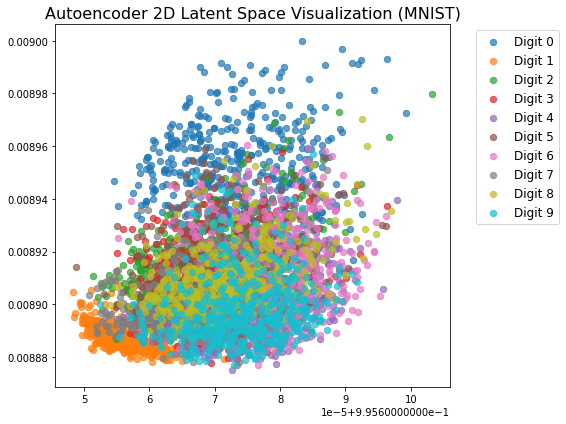

In [22]:
# draw 2 dim decrete graph（match the paper）
plt.figure(figsize=(8, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

for digit in range(10):
    # sample of 'current digit'
    mask = (y_test_sampled == digit)
    plt.scatter(z_test[mask, 0], z_test[mask, 1], 
                color=colors[digit], 
                label=f'Digit {digit}',
                alpha=0.7, 
                s=40)

plt.title('Autoencoder 2D Latent Space Visualization (MNIST)', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.tight_layout()
plt.show()


#with torch.no_grad():
#    z_train = model.encode(x_train_tensor).cpu().numpy()
#
#plt.figure(figsize=(12, 10))
#for digit in range(10):
#    mask = (y_train_sampled == digit)
#    plt.scatter(z_train[mask, 0], z_train[mask, 1], 
#                color=colors[digit], 
#                label=f'Digit {digit}',
#                alpha=0.6, 
#                s=30)
#
#plt.title('Autoencoder 2D Latent Space (Training Set)', fontsize=16)
#plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
#plt.axis('off')
#plt.tight_layout()
#plt.show()

# VAE

### Structure

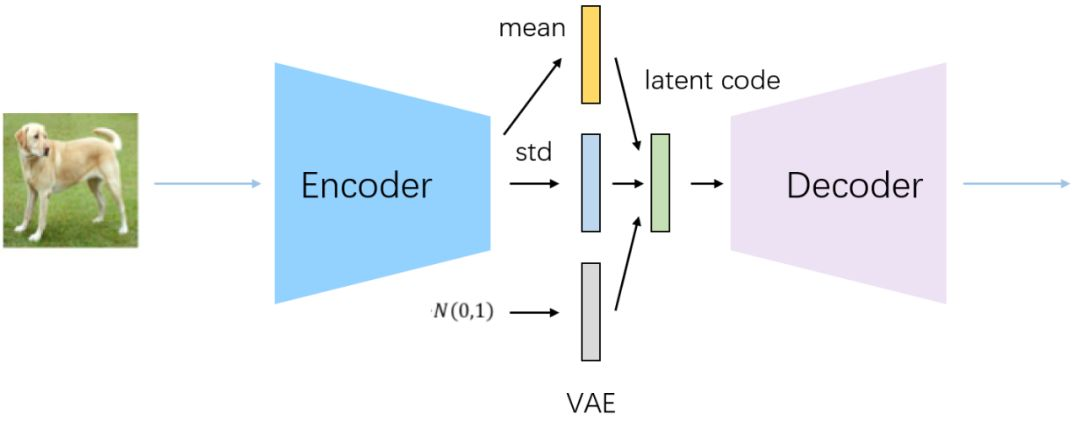

In [23]:
class VAE(nn.Module):
    def __init__(self, latent_dim=2):
        super(VAE, self).__init__()
        self.latent_dim = latent_dim
        
        # encoder-->mean & std
        self.encoder = nn.Sequential(
            nn.Linear(784, 1000),
            nn.ReLU(),
            nn.Linear(1000, 500),
            nn.ReLU(),
            nn.Linear(500, 250),
            nn.ReLU()
        )
        
        # mean & std
        self.fc_mu = nn.Linear(250, latent_dim)
        self.fc_logvar = nn.Linear(250, latent_dim)
        
        # decoder
        self.decoder = nn.Sequential(
            nn.Linear(latent_dim, 250),
            nn.ReLU(),
            nn.Linear(250, 500),
            nn.ReLU(),
            nn.Linear(500, 1000),
            nn.ReLU(),
            nn.Linear(1000, 784),
            nn.Sigmoid()  # 输出在[0,1]之间
        )
    
    def reparameterize(self, mu, logvar):
        #z = mu + std * eps
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std
    
    def forward(self, x):
        # encoder
        h = self.encoder(x)
        mu = self.fc_mu(h)
        logvar = self.fc_logvar(h)
        
        # reparameterize
        z = self.reparameterize(mu, logvar)
        
        # decoder
        x_recon = self.decoder(z)
        
        return x_recon, mu, logvar, z
    
    def encode(self, x):
        h = self.encoder(x)
        mu = self.fc_mu(h)
        return mu
    
    def generate(self, z):
        return self.decoder(z)

# VAEloss：binary_cross_entropy + KL divergence
def vae_loss(x_recon, x, mu, logvar):
    # binary_cross_entropy
    recon_loss = nn.functional.binary_cross_entropy(x_recon, x, reduction='sum')
    
    # KL divergence：measure the difference from the standard normal distribution
    kl_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    
    return recon_loss + kl_loss

# init model & opti
latent_dim = 2  # 2 dim latent space
model = VAE(latent_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)

# 构建数据加载器
train_loader = DataLoader(
    dataset=TensorDataset(x_train_tensor),
    batch_size=128,
    shuffle=True
)

In [24]:
# train
epochs = 50
for epoch in range(epochs):
    model.train()
    train_loss = 0.0
    
    for batch in train_loader:
        x = batch[0]
        optimizer.zero_grad()
        
        x_recon, mu, logvar, z = model(x)
        loss = vae_loss(x_recon, x, mu, logvar)
        
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    # loss
    model.eval()
    with torch.no_grad():
        x_recon_test, mu_test, logvar_test, _ = model(x_test_tensor)
        val_loss = vae_loss(x_recon_test, x_test_tensor, mu_test, logvar_test).item()
    
    if epoch % 5 == 0:
        avg_train_loss = train_loss / len(x_train_tensor)
        avg_val_loss = val_loss / len(x_test_tensor)
        print(f'Epoch [{epoch}/{epochs}], Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}')

Epoch [0/50], Train Loss: 250.4519, Val Loss: 203.4372
Epoch [5/50], Train Loss: 185.8869, Val Loss: 183.9638
Epoch [10/50], Train Loss: 165.7365, Val Loss: 166.6933
Epoch [15/50], Train Loss: 156.2610, Val Loss: 160.1724
Epoch [20/50], Train Loss: 150.5542, Val Loss: 157.0399
Epoch [25/50], Train Loss: 146.6076, Val Loss: 156.6156
Epoch [30/50], Train Loss: 143.8336, Val Loss: 155.1368
Epoch [35/50], Train Loss: 142.3469, Val Loss: 155.0787
Epoch [40/50], Train Loss: 140.1785, Val Loss: 154.5285
Epoch [45/50], Train Loss: 138.7887, Val Loss: 154.8591


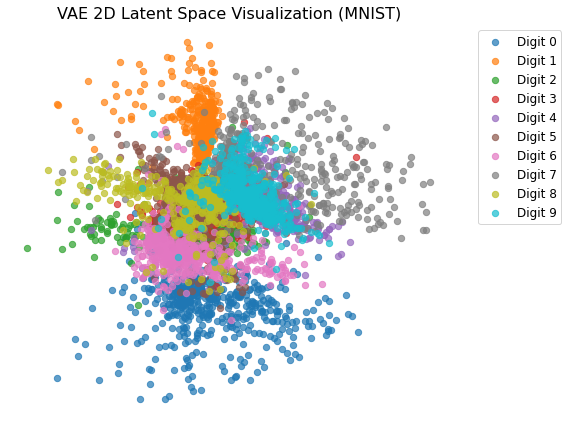

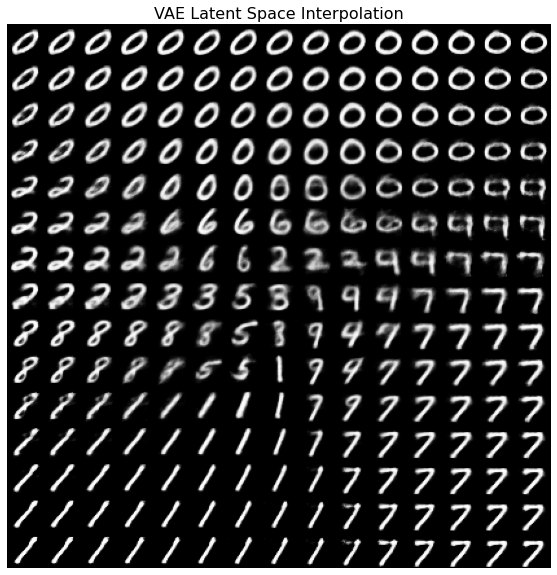

In [25]:
# ---------------------- visualize VAE latent space ----------------------
model.eval()
with torch.no_grad():
    z_test = model.encode(x_test_tensor).cpu().numpy()

# draw 2 dim decrete graph
plt.figure(figsize=(8, 6))
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', 
          '#8c564b', '#e377c2', '#7f7f7f', '#bcbd22', '#17becf']

for digit in range(10):
    mask = (y_test_sampled == digit)
    plt.scatter(z_test[mask, 0], z_test[mask, 1], 
                color=colors[digit], 
                label=f'Digit {digit}',
                alpha=0.7, 
                s=40)

plt.title('VAE 2D Latent Space Visualization (MNIST)', fontsize=16)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize=12)
plt.axis('off')
plt.tight_layout()
plt.show()

# Visualization interpolation result of latent space
n = 15  # graph matrix
digit_size = 28
figure = np.zeros((digit_size * n, digit_size * n))

# 2 dim grid 
grid_x = np.linspace(-4, 4, n)
grid_y = np.linspace(-4, 4, n)

model.eval()
with torch.no_grad():
    for i, yi in enumerate(grid_y):
        for j, xi in enumerate(grid_x):
            z_sample = torch.tensor([[xi, yi]], dtype=torch.float32).to(device)
            x_recon = model.generate(z_sample)
            digit = x_recon.cpu().numpy().reshape(digit_size, digit_size)
            figure[i * digit_size: (i + 1) * digit_size,
                   j * digit_size: (j + 1) * digit_size] = digit

plt.figure(figsize=(10, 10))
plt.imshow(figure, cmap='Greys_r')
plt.axis('off')
plt.title('VAE Latent Space Interpolation', fontsize=16)
plt.show()